<a href="https://colab.research.google.com/github/prhuft/pytorch-deep-learning/blob/main/extras/exercises/01_pytorch_workflow_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. PyTorch Workflow Exercise Template

The following is a template for the PyTorch workflow exercises.

It's only starter code and it's your job to fill in the blanks.

Because of the flexibility of PyTorch, there may be more than one way to answer the question.

Don't worry about trying to be *right* just try writing code that suffices the question.

You can see one form of [solutions on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions) (but try the exercises below yourself first!).

In [39]:
# Import necessary libraries
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt


In [40]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'


## 1. Create a straight line dataset using the linear regression formula (`weight * X + bias`).
  * Set `weight=0.3` and `bias=0.9` there should be at least 100 datapoints total.
  * Split the data into 80% training, 20% testing.
  * Plot the training and testing data so it becomes visual.

Your output of the below cell should look something like:
```
Number of X samples: 100
Number of y samples: 100
First 10 X & y samples:
X: tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900])
y: tensor([0.9000, 0.9030, 0.9060, 0.9090, 0.9120, 0.9150, 0.9180, 0.9210, 0.9240,
        0.9270])
```

Of course the numbers in `X` and `y` may be different but ideally they're created using the linear regression formula.

In [41]:
# Create the data parameters
X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)

# Make X and y using linear regression feature
bias = 0.9
weights = 0.3
y = X * bias + weights

print(f"Number of X samples: {len(X)}")
print(f"Number of y samples: {len(y)}")
print(f"First 10 X & y samples:\nX: {X[:10]}\ny: {y[:10]}")

Number of X samples: 50
Number of y samples: 50
First 10 X & y samples:
X: tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])
y: tensor([[0.3000],
        [0.3180],
        [0.3360],
        [0.3540],
        [0.3720],
        [0.3900],
        [0.4080],
        [0.4260],
        [0.4440],
        [0.4620]])


In [42]:
# Split the data into training and testing
torch.manual_seed(42)
train_split = int(0.8 * len(X))
shuffled_idcs = torch.arange(len(X))[torch.randperm(len(X))]
train_idcs = shuffled_idcs[:train_split]
test_idcs = shuffled_idcs[train_split:]
X_train, y_train = X[train_idcs], y[train_idcs]
X_test, y_test = X[test_idcs], y[test_idcs]

In [43]:
# Plot the training and testing data
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    fig, ax = plt.subplots()
    ax.scatter(train_data, train_labels, label='training', s=4, c='b')
    ax.scatter(test_data, test_labels, label='testing', s=4, c='g')
    if predictions is not None:
      ax.scatter(test_data, predictions, label='predictions', s=4, c='r')
    ax.legend()
    plt.show()


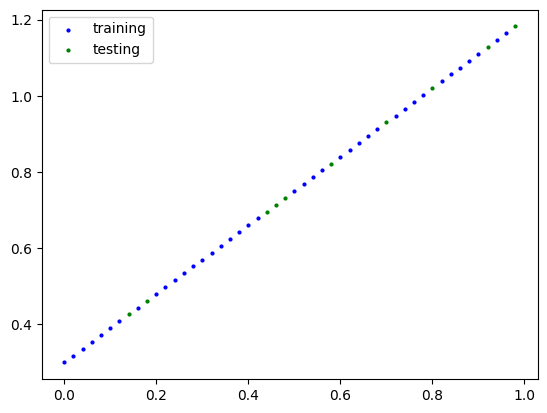

In [44]:
plot_predictions(train_data=X_train, train_labels=y_train,
                 test_data=X_test, test_labels=y_test)

## 2. Build a PyTorch model by subclassing `nn.Module`.
  * Inside should be a randomly initialized `nn.Parameter()` with `requires_grad=True`, one for `weights` and one for `bias`.
  * Implement the `forward()` method to compute the linear regression function you used to create the dataset in 1.
  * Once you've constructed the model, make an instance of it and check its `state_dict()`.
  * **Note:** If you'd like to use `nn.Linear()` instead of `nn.Parameter()` you can.

In [45]:
# Create PyTorch linear regression model by subclassing nn.Module
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [46]:
# Instantiate the model and put it to the target device
model = LinearRegressionModel()
model.to(device)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

## 3. Create a loss function and optimizer using `nn.L1Loss()` and `torch.optim.SGD(params, lr)` respectively.
  * Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
  * Write a training loop to perform the appropriate training steps for 300 epochs.
  * The training loop should test the model on the test dataset every 20 epochs.

In [47]:
# Create the loss function and optimizer
loss_func = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [48]:
# Training loop
# Explanatory note (distilled from a Gemini explanation) on how the seemingly
# disconnected model, loss,
# and optimizer objects are tied together:
# - the optimizer instances keeps an internal reference to the model parameters
# - when the forward pass is applied, because the model's parameters are tensors
#   that require_grad, a computational graph is built in the background, tracking
#   these operations and their dependencies
# - the loss is computed based on y_pred (which was derived from the model's
#   parameters) and y_train. Since y_pred has gradient tracking enabled, the
#   loss tensor also has gradient tracking enabled, and it's part of the same
#   computational graph.
# - in a nutshell, these various components have access to the parameters and
#   computational graph under the hood, and operations are tracked when
#   require_grad is true.


# Train model for 300 epochs
epochs = 300

# Send data to target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training

    # Put model in train mode
    model.train()

    # 1. Forward pass
    y_pred = model(X_train)

    # 2. Calculate loss
    loss = loss_func(y_pred, y_train)

    # 3. Zero gradients
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing

    ### Perform testing every 20 epochs
    if epoch % 20 == 0:

        # Put model in evaluation mode and setup inference context
        with torch.inference_mode():

            # 1. Forward pass
            test_pred = model(X_test)

            # 2. Calculate test loss
            test_loss = loss_func(test_pred, y_test)

            # Print out what's happening
            print(f"Epoch: {epoch} | Train loss: {loss:.3f} | Test loss: {test_loss:.3f}")

Epoch: 0 | Train loss: 2.000 | Test loss: 2.135
Epoch: 20 | Train loss: 1.756 | Test loss: 1.881
Epoch: 40 | Train loss: 1.512 | Test loss: 1.628
Epoch: 60 | Train loss: 1.267 | Test loss: 1.374
Epoch: 80 | Train loss: 1.023 | Test loss: 1.121
Epoch: 100 | Train loss: 0.779 | Test loss: 0.867
Epoch: 120 | Train loss: 0.534 | Test loss: 0.614
Epoch: 140 | Train loss: 0.323 | Test loss: 0.381
Epoch: 160 | Train loss: 0.220 | Test loss: 0.257
Epoch: 180 | Train loss: 0.180 | Test loss: 0.191
Epoch: 200 | Train loss: 0.163 | Test loss: 0.156
Epoch: 220 | Train loss: 0.150 | Test loss: 0.135
Epoch: 240 | Train loss: 0.137 | Test loss: 0.122
Epoch: 260 | Train loss: 0.126 | Test loss: 0.112
Epoch: 280 | Train loss: 0.116 | Test loss: 0.102


## 4. Make predictions with the trained model on the test data.
  * Visualize these predictions against the original training and testing data (**note:** you may need to make sure the predictions are *not* on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

In [49]:
# Make predictions with the model
with torch.inference_mode():
    y_preds = model(X_test)

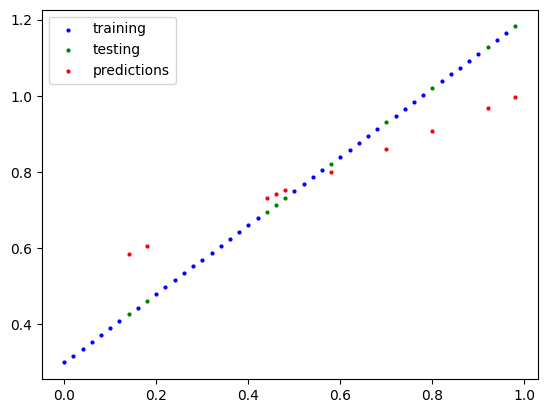

In [50]:
# Plot the predictions (these may need to be on a specific device)
plot_predictions(
    X_train.cpu().numpy(),
    y_train.cpu().numpy(),
    X_test.cpu().numpy(),
    y_test.cpu().numpy(),
    predictions=y_preds.cpu().numpy()
)

## 5. Save your trained model's `state_dict()` to file.
  * Create a new instance of your model class you made in 2. and load in the `state_dict()` you just saved to it.
  * Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

In [51]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '01_pytorch_workflow_exercise_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)
print(f'Saved model to: {MODEL_SAVE_PATH}')

Saved model to: models/01_pytorch_workflow_exercise_model.pth


In [52]:
# Create new instance of model and load saved state dict (make sure to put it on the target device)
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model.to(device)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [53]:
# Make predictions with loaded model and compare them to the previous
with torch.inference_mode():
    loaded_preds = loaded_model(X_test)

print(loaded_preds == y_preds)

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')


In [54]:
loss_func = nn.L1Loss()
optimizer = torch.optim.SGD(params=loaded_model.parameters(), lr=0.01) # try slightly higher learning rate

In [55]:
# Bonus: update the model since the agreement was fairly poor earlier

# Train model for 300 epochs
epochs = 300

# Send data to target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training

    # Put model in train mode
    loaded_model.train()

    # 1. Forward pass
    y_pred = loaded_model(X_train)

    # 2. Calculate loss
    loss = loss_func(y_pred, y_train)

    # 3. Zero gradients
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing

    ### Perform testing every 20 epochs
    if epoch % 20 == 0:

        # Put model in evaluation mode and setup inference context
        with torch.inference_mode():

            # 1. Forward pass
            test_pred = model(X_test)

            # 2. Calculate test loss
            test_loss = loss_func(test_pred, y_test)

            # Print out what's happening
            print(f"Epoch: {epoch} | Train loss: {loss:.3f} | Test loss: {test_loss:.3f}")

Epoch: 0 | Train loss: 0.106 | Test loss: 0.094
Epoch: 20 | Train loss: 0.095 | Test loss: 0.094
Epoch: 40 | Train loss: 0.085 | Test loss: 0.094
Epoch: 60 | Train loss: 0.074 | Test loss: 0.094
Epoch: 80 | Train loss: 0.064 | Test loss: 0.094
Epoch: 100 | Train loss: 0.054 | Test loss: 0.094
Epoch: 120 | Train loss: 0.043 | Test loss: 0.094
Epoch: 140 | Train loss: 0.033 | Test loss: 0.094
Epoch: 160 | Train loss: 0.023 | Test loss: 0.094
Epoch: 180 | Train loss: 0.012 | Test loss: 0.094
Epoch: 200 | Train loss: 0.002 | Test loss: 0.094
Epoch: 220 | Train loss: 0.005 | Test loss: 0.094
Epoch: 240 | Train loss: 0.005 | Test loss: 0.094
Epoch: 260 | Train loss: 0.005 | Test loss: 0.094
Epoch: 280 | Train loss: 0.005 | Test loss: 0.094


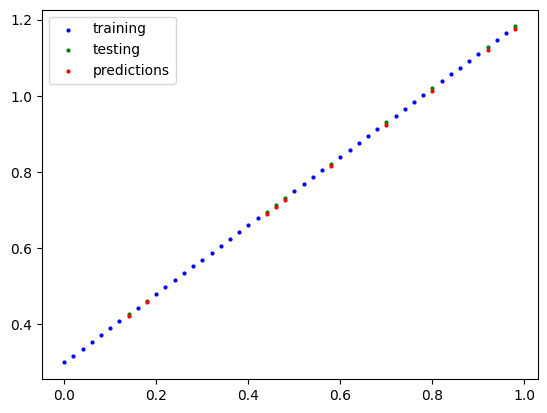

In [56]:
with torch.inference_mode():
  y_preds = loaded_model(X_test)
plot_predictions(
    X_train.cpu().numpy(),
    y_train.cpu().numpy(),
    X_test.cpu().numpy(),
    y_test.cpu().numpy(),
    predictions=y_preds.cpu().numpy()
)